In [1]:
!pip -q install pandas networkx matplotlib requests

In [2]:
import os
import requests

# 1) Proteínas "semilla" asociadas a Alzheimer (Homo sapiens)
seed_genes = [
    "APP", "PSEN1", "PSEN2", "APOE", "MAPT",
    "TREM2", "CLU", "ABCA7", "SORL1", "BIN1", "PICALM"
]

# 2) Parámetros de STRING
species = 9606  # Homo sapiens
required_score = 700  # 0-1000: filtra por confianza (700 = alta)
network_flavor = "confidence"  # tipo de score usado por STRING

# 3) Endpoint de STRING (devuelve la red en TSV)
url = "https://string-db.org/api/tsv/network"

# 4) Preparar carpeta de salida
os.makedirs("data", exist_ok=True)
out_path = "data/ppi_string.tsv"

# 5) STRING recibe "identifiers" como una lista separada por saltos de línea
params = {
    "identifiers": "\n".join(seed_genes),
    "species": species,
    "required_score": required_score,
    "network_flavor": network_flavor
}

print("Descargando datos desde STRING...")
resp = requests.post(url, data=params, timeout=60)
resp.raise_for_status()

with open(out_path, "wb") as f:
    f.write(resp.content)

print(f"Listo ✅ Guardado en: {out_path}")
print("Primeras líneas del archivo:")
print(resp.text.splitlines()[:5])


Descargando datos desde STRING...
Listo ✅ Guardado en: data/ppi_string.tsv
Primeras líneas del archivo:
['stringId_A\tstringId_B\tpreferredName_A\tpreferredName_B\tncbiTaxonId\tscore\tnscore\tfscore\tpscore\tascore\tescore\tdscore\ttscore', '9606.ENSP00000252486\t9606.ENSP00000377015\tAPOE\tPICALM\t9606\t0.773\t0\t0\t0\t0\t0\t0\t0.773', '9606.ENSP00000252486\t9606.ENSP00000263094\tAPOE\tABCA7\t9606\t0.774\t0\t0\t0\t0.047\t0\t0\t0.773', '9606.ENSP00000252486\t9606.ENSP00000316779\tAPOE\tBIN1\t9606\t0.908\t0\t0\t0\t0.043\t0\t0.54\t0.808', '9606.ENSP00000252486\t9606.ENSP00000326366\tAPOE\tPSEN1\t9606\t0.956\t0\t0\t0\t0\t0\t0\t0.956']


In [3]:
import pandas as pd
import networkx as nx

df = pd.read_csv("data/ppi_string.tsv", sep="\t")

# STRING suele traer columnas como:
# preferredName_A, preferredName_B, score
# (a veces "score" puede venir con otro nombre dependiendo del endpoint)
print("Columnas disponibles:", df.columns.tolist())
df.head()


Columnas disponibles: ['stringId_A', 'stringId_B', 'preferredName_A', 'preferredName_B', 'ncbiTaxonId', 'score', 'nscore', 'fscore', 'pscore', 'ascore', 'escore', 'dscore', 'tscore']


,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
0,9606.ENSP00000252486,9606.ENSP00000377015,APOE,PICALM,9606,0.773,0,0,0.0,0.000,0.0,0.00,0.773
1,9606.ENSP00000252486,9606.ENSP00000263094,APOE,ABCA7,9606,0.774,0,0,0.0,0.047,0.0,0.00,0.773
2,9606.ENSP00000252486,9606.ENSP00000316779,APOE,BIN1,9606,0.908,0,0,0.0,0.043,0.0,0.54,0.808
3,9606.ENSP00000252486,9606.ENSP00000326366,APOE,PSEN1,9606,0.956,0,0,0.0,0.000,0.0,0.00,0.956
4,9606.ENSP00000252486,9606.ENSP00000355747,APOE,PSEN2,9606,0.961,0,0,0.0,0.044,0.0,0.00,0.961


In [4]:
# Construir grafo
G = nx.from_pandas_edgelist(
    df,
    source="preferredName_A",
    target="preferredName_B",
    edge_attr=True  # guarda el score como atributo
)

print("✅ Red construida")
print("Nodos (proteínas):", G.number_of_nodes())
print("Aristas (interacciones):", G.number_of_edges())


✅ Red construida
Nodos (proteínas): 11
Aristas (interacciones): 44


In [5]:
# Grado = cuántas conexiones tiene cada proteína
degree_dict = dict(G.degree())
top_hubs = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 proteínas más conectadas (hubs):")
for protein, deg in top_hubs:
    print(f"- {protein}: {deg} conexiones")


Top 10 proteínas más conectadas (hubs):
- APOE: 10 conexiones
- PICALM: 9 conexiones
- SORL1: 9 conexiones
- APP: 9 conexiones
- PSEN2: 8 conexiones
- TREM2: 8 conexiones
- ABCA7: 7 conexiones
- BIN1: 7 conexiones
- PSEN1: 7 conexiones
- MAPT: 7 conexiones


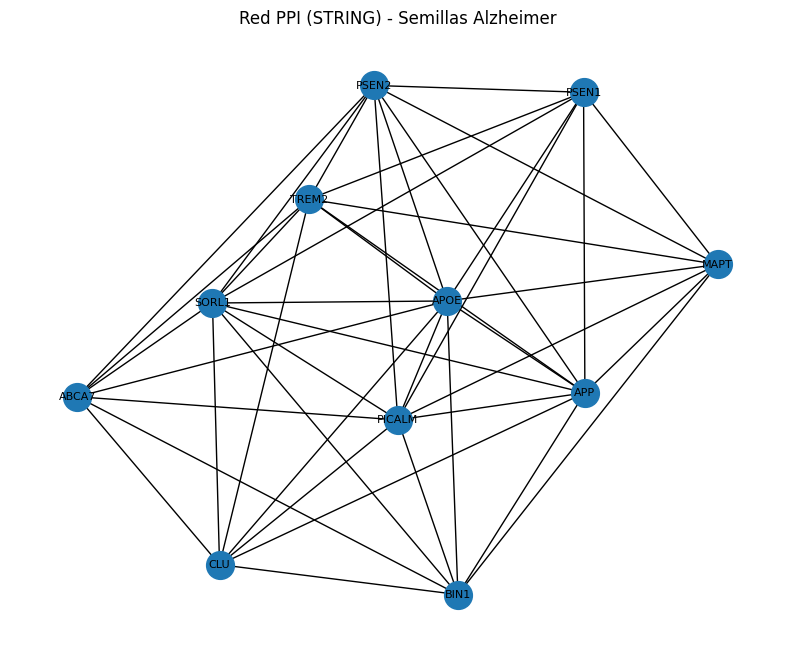

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # layout para posicionar nodos
nx.draw_networkx(G, pos=pos, with_labels=True, node_size=400, font_size=8)
plt.title("Red PPI (STRING) - Semillas Alzheimer")
plt.axis("off")
plt.show()
